In [1]:
suppressMessages({
    require(Seurat)
    library(dplyr)
    library(ggtree)
    library(phangorn)
    library(cluster)
    library(ggplot2)
    library(hash)
    library(dendextend)
    library(ape)
})

PercentAbove <- function(x, threshold) { return(length(x = x[x > threshold]) / length(x = x)) }
get_pct_matrix <- function(object, vars, cells, group.by){
    data.features <- FetchData(object = object, vars = vars, cells = cells)
    data.features$id <- if (!is.null(x = group.by)) {
        object[[group.by, drop = TRUE]][cells, drop = TRUE]
    }
    
    res <- Reduce(rbind, lapply(X = unique(x = data.features$id), FUN = function(ident) {
        data.use <- data.features[data.features$id == ident, 1:(ncol(x = data.features) - 1), drop = FALSE]
        pct.exp <- apply(X = data.use, MARGIN = 2, FUN = PercentAbove, threshold = 0)
        return(pct.exp)
    }))
    rownames(res) <- unique(data.features$id)
    res <- t(res)
    return(res)
}

source("Trinarization_score.R")


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count




In [3]:
tree <- read.tree('nwk/chicken.cerebellar_subnuclei.dend.nwk')
# we focus on region variant excitatory neurons rather than invariant inhibitory neurons
chicken <- readRDS('../1.update_atlas/GSM4873767_chicken_data.coding_genes.rds')
chicken@meta.data$cell_type <- factor(chicken@meta.data$cell_type, levels = labels(as.dendrogram(tree)))
markers <- read.table('../2.ohnolog_significance/1.markers/chicken.ex.DEGs.subnuclei_class.txt', header = T)
Idents(chicken)<-'cell_type'

In [9]:
TFs <- read.table('/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/01.data/07.species_signals/6.TF_vs_species_signals/TFs/Ggal.predicted_TFs.name.txt', header = T)
TFs <- TFs[TFs$prediction == 'True', 'name']
length(TFs)

[1] 1310

In [11]:
exp <- trinarize(chicken, 0.1, label = "cell_type")
binary_matrix <- exp
binary_matrix[binary_matrix < 0.05] = 0
binary_matrix[binary_matrix != 0] = 1

In [12]:
# predict ancestral states for class A duplication
phyDat.binary <- phyDat(t(binary_matrix), type = "USER", levels = c(0,1))
anc.acctran <- ancestral.pars(tree, phyDat.binary, "ACCTRAN", return = "prob")
predicted <- matrix(NA, nrow = length(anc.acctran), ncol = nrow(binary_matrix))
tmp <- lapply(anc.acctran, FUN = function(x) { apply(x, 1, FUN = function(y) {
  if (1 %in% y){c(0,1)[which(y > 0.5)]} else {0}})}) # simple decision, prob > 0.5 is 1 
node_tip <- length(tree$tip.label) + tree$Nnode
anc.acctran.binary <- matrix(unlist(tmp), nrow = node_tip, byrow = T)
rownames(anc.acctran.binary) <- names(tmp)

In [13]:
tips <- tree$tip.label
inodes <- (length(tree$tip.label) + 2):(length(tree$tip.label) + tree$Nnode)

In [14]:
binary_matrix <- binary_matrix[,rownames(anc.acctran.binary)[1:length(tree$tip.label)]]
gain_loss <- hash()

for (i in c(inodes, tips)){
#for (i in c('Lat.A1')){
    if (!is.na(as.integer(i))){
        i <- as.integer(i)
    }
    anode <- getMRCA(tree, c(i,i)) # ancestral node
    anc <- anc.acctran.binary[anode, ] # binarized ancestral pattern
    # gain or loss pattern
    gain <- anc.acctran.binary[1:length(tree$tip.label), (anc.acctran.binary[i, ] - anc.acctran.binary[anode, ]) == 1, drop = FALSE]
    loss <- anc.acctran.binary[1:length(tree$tip.label), (anc.acctran.binary[i, ] - anc.acctran.binary[anode, ]) == -1, drop = FALSE]
    
    gains <- c()
    losses <- c()
    if (ncol(gain) >= 1){
        for (x in 1:ncol(gain)){
            pattern <- gain[,x]
            gains <- c(gains, names(apply(binary_matrix, 1, function(x) all(x == pattern)))[apply(binary_matrix, 1, function(x) all(x == pattern))])
        }
    }
    if (ncol(loss) >= 1){
        for (x in 1:ncol(loss)){
            pattern <- loss[,x]
            losses <- c(losses, names(apply(binary_matrix, 1, function(x) all(x == pattern)))[apply(binary_matrix, 1, function(x) all(x == pattern))])
        }
    }
    
    hash_i <- hash()
    hash_i[['gain']] <- if (is.null(gains)) NA else unique(gains)
    hash_i[['loss']] <- if (is.null(losses)) NA else unique(losses)
    i <- as.character(i)
    gain_loss[[i]] <- hash_i
}

Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


In [15]:
for (key in keys(gain_loss)){
    for (i in c('gain','loss')){
        line <- paste(key, i, gain_loss[[key]][[i]], sep = "\t")
        write(line, file = 'Ggal.gain_loss.txt', append = TRUE)
    }
}

In [16]:
info <- hash()
for (i in c(inodes, tips)){
    tmp <- gain_loss[[i]][['gain']]
    n_gain <- length(tmp[!is.na(tmp)])
    n_gain_TFs <- sum(tmp[!is.na(tmp)] %in% TFs)
    tmp <- gain_loss[[i]][['loss']]
    n_loss <- length(tmp[!is.na(tmp)])
    n_loss_TFs <- sum(tmp[!is.na(tmp)] %in% TFs)
    text <- paste0('gain:', n_gain, ';', n_gain_TFs, '\nloss:', n_loss, ';', n_loss_TFs)
    
    if (!is.na(as.integer(i))){
        info[[i]] <- text
    } else {
        i = as.character(names(setNames(tips, 1:length(tips))[setNames(tips, 1:length(tips)) == i]))
        info[[i]] <- text 
    }
}

Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


In [17]:
p = ggtree(tree, ladderize=F) + geom_tiplab() + ggtitle("ggtree")
edge=data.frame(tree$edge, edge_text= vapply(as.character(tree$edge[,2]), FUN = function(x){info[[x]]}, FUN.VALUE = character(1)) )
colnames(edge)=c("parent", "node", "edge_text")
p <- p %<+% edge + geom_label(aes(x=branch, label=edge_text)) + geom_text2(aes(subset = !isTip, label = node))

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_label()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_label()`).”


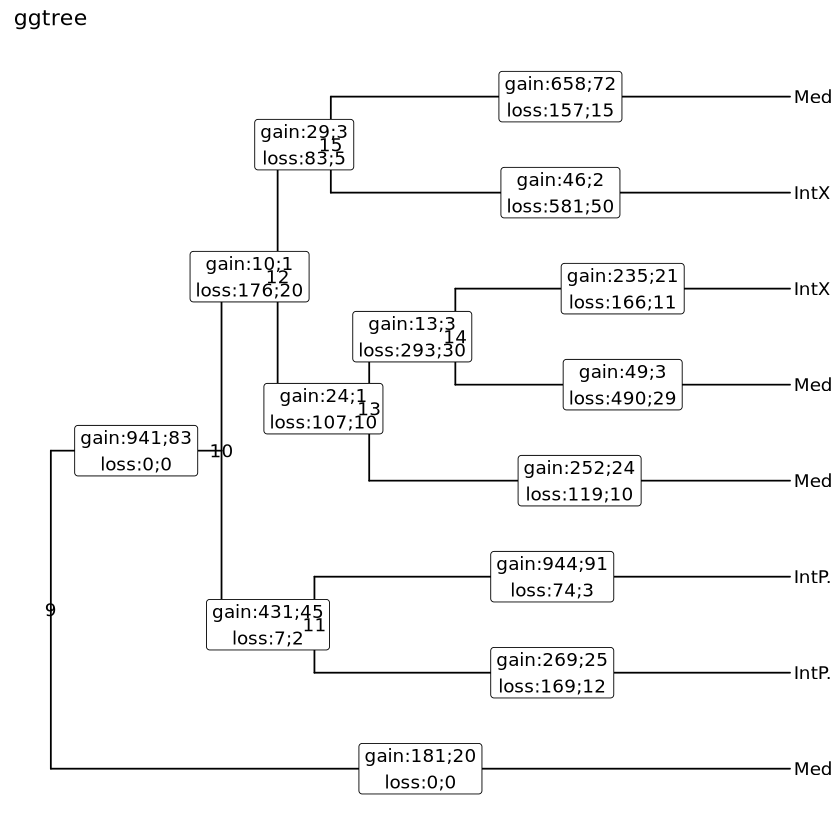

In [18]:
p
ggsave(filename = "results/chicken.cerebellar_nuclei.gene_gain_loss.pdf", p, width = 7, height = 7)

In [63]:
p1 <- DotPlot(mouse, features = c(
                         gain_loss[['Lat.A']][['gain']]
                        
                         #gain_loss[['Lat.A']][['loss']]
                        )) + theme(axis.text.x=element_text(angle = 90, vjust = 0.5))

p2 <- DotPlot(mouse, features = c(
                         gain_loss[['Lat.B']][['gain']],
                         gain_loss[['Lat.B']][['loss']]
                        )) + theme(axis.text.x=element_text(angle = 90, vjust = 0.5))

In [24]:
test <- FindMarkers(human, `ident.1` = "Lat.A", `ident.2` = "IntA.A")

In [27]:
test[rownames(test) %in% TFs & test$p_val_adj < 0.01,]

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
Esrrg 1.172659e-19 -1.0684217 1.000 1.000 2.250332e-15
Prox1 1.986243e-17 -4.4151648 0.049 0.509 3.811600e-13
Maf   7.329112e-12 -4.4455576 0.189 0.555 1.406457e-07
Meis2 1.251419e-08  0.9476402 0.958 0.800 2.401472e-04

In [41]:
test <- read.delim('/mnt/data01/yuanzhen/01.Vertebrate_cell_evo/13.case_analysis/1.cerebellum/6.SuppTables/SuppTable.cerebellar_subnuclei_markers_info.Hsap.txt')

In [38]:
gain_loss[['Lat.B']][['gain']][gain_loss[['Lat.B']][['gain']] %in% TFs]


[1] "FOSB"   "ZNF772" "FOXQ1"  "NR4A2"

In [43]:
test[test$Gene_name %in% gain_loss[['Lat.B']][['gain']], ]

EnsemblID       Gene_name TFs   ohnologs family                 
371 ENSG00000153234 NR4A2      TRUE  TRUE    NR4A3,NR4A2,NR4A1      
406 ENSG00000188483 IER5L     FALSE  TRUE    IER5,IER5L,IER2        
418 ENSG00000157335 CLEC18C   FALSE FALSE                           
465 ENSG00000173641 HSPB7     FALSE FALSE                           
466 ENSG00000144771 LRTM1     FALSE FALSE                           
474 ENSG00000111057 KRT18     FALSE FALSE                           
491 ENSG00000164379 FOXQ1      TRUE FALSE                           
567 ENSG00000178301 AQP11     FALSE  TRUE    AQP12B,AQP12A,AQP11    
571 ENSG00000187193 MT1X      FALSE FALSE                           
581 ENSG00000219200 RNASEK    FALSE FALSE                           
607 ENSG00000205220 PSMB10    FALSE FALSE                           
608 ENSG00000128285 MCHR1     FALSE FALSE                           
611 ENSG00000100445 SDR39U1   FALSE FALSE                           
633 ENSG00000175768 TOMM5     FALSE FALSE                           
635 ENSG00000120875 DUSP4     FALSE FALSE                           
667 ENSG00000048162 NOP16     FALSE FALSE                           
673 ENSG00000169564 PCBP1     FALSE  TRUE    PCBP4,PCBP1,PCBP2,PCBP3
710 ENSG00000038210 PI4K2B    FALSE  TRUE    PI4K2B,PI4K2A          
712 ENSG00000135914 HTR2B     FALSE  TRUE    HTR2C,HTR2B,HTR2A

In [ ]:
DotPlot(chicken, features = c('PDE1A', 'NEUROD2', 'IRX2', 'PAX6', 'LHX9', 'ATOH1'))